(0.0, 200.0)

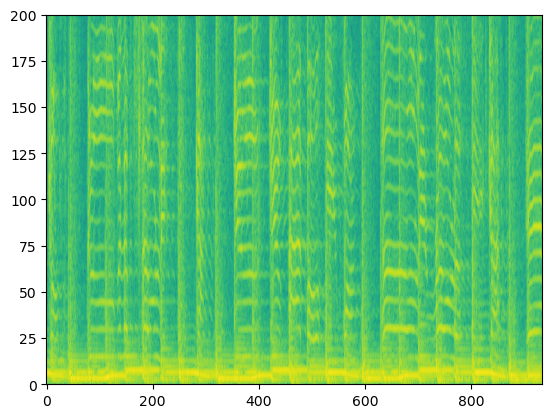

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.io import wavfile

def blackman_harris_window(N):
    """
    Create a Blackman-Harris Window
    
    Parameters
    ----------
    N: int
        Length of window
    
    Returns
    -------
    ndarray(N): Samples of the window
    """
    a0 = 0.35875
    a1 = 0.48829
    a2 = 0.14128
    a3 = 0.01168
    t = np.arange(N)/N
    return a0 - a1*np.cos(2*np.pi*t) + a2*np.cos(4*np.pi*t) - a3*np.cos(6*np.pi*t)

def stft(x, w, h, win_fn=blackman_harris_window):
    """
    Compute the complex Short-Time Fourier Transform (STFT)
    Parameters
    ----------
    x: ndarray(N)
        Full audio clip of N samples
    w: int
        Window length
    h: int
        Hop length
    win_fn: int -> ndarray(N)
        Window function
    
    Returns
    -------
    ndarray(w, nwindows, dtype=np.complex) STFT
    """
    N = len(x)
    nwin = int(np.ceil((N-w)/h))+1
    # Make a 2D array
    # The rows correspond to frequency bins
    # The columns correspond to windows moved forward in time
    S = np.zeros((w, nwin), dtype=complex)
    # Loop through all of the windows, and put the fourier
    # transform amplitudes of each window in its own column
    for j in range(nwin):
        # Pull out the audio in the jth window
        xj = x[h*j:h*j+w]
        # Zeropad if necessary
        if len(xj) < w:
            xj = np.concatenate((xj, np.zeros(w-len(xj))))
        # Apply window function
        xj = win_fn(w)*xj
        # Put the fourier transform into S
        S[:, j] = np.fft.fft(xj)
    return S


def amplitude_to_db(S, amin=1e-10, ref=1):
    """
    Convert an amplitude spectrogram to be expressed in decibels
    
    Parameters
    ----------
    S: ndarray(win, T)
        Amplitude spectrogram
    amin: float
        Minimum accepted value for the spectrogram
    ref: int
        0dB reference amplitude
        
    Returns
    -------
    ndarray(win, T)
        The dB spectrogram
    """
    SLog = 20.0*np.log10(np.maximum(amin, S))
    SLog -= 20.0*np.log10(np.maximum(amin, ref))
    return SLog

sr, x = wavfile.read("beatles.wav")
win = 2048
hop = 512


S = stft(x, win, hop)
Sdb = amplitude_to_db(np.abs(S))
plt.imshow(Sdb, aspect='auto')
plt.ylim([0, 200])

(0.0, 200.0)

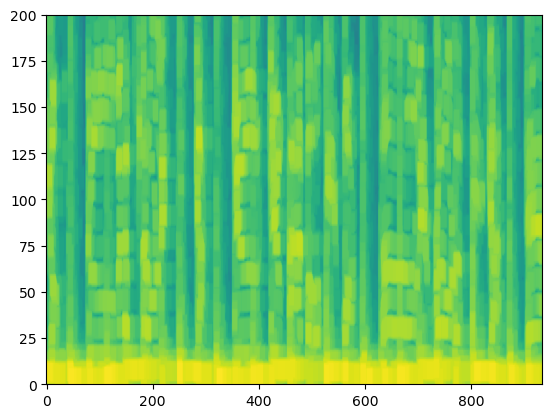

In [6]:
from scipy.ndimage import maximum_filter
SdbMax = maximum_filter(Sdb, size=(10, 10))
plt.imshow(SdbMax, aspect='auto')
plt.ylim([0, 200])

(0.0, 100.0)

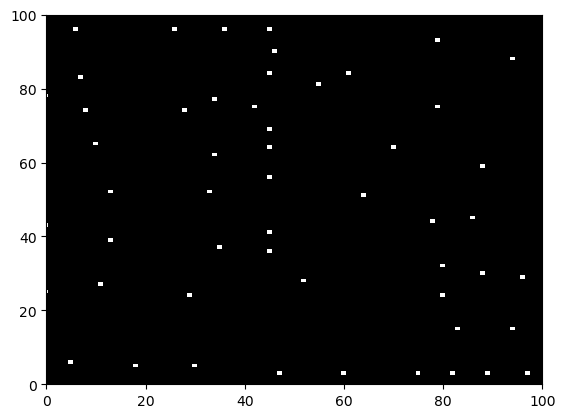

In [11]:
plt.imshow(Sdb == SdbMax, aspect='auto', cmap='gray')
plt.ylim([0, 100])
plt.xlim([0, 100])

In [ ]:
plt.figure(figsize=(10, 5))
start = 50
col1 = Sdb[:, start]
col2 = Sdb[:, start+1]
diff = np.abs(col2 - col1)
novelty = np.mean(diff)
plt.subplot(311)
plt.plot(col1)
plt.title("Column {}".format(start))
plt.subplot(312)
plt.plot(col2)
plt.title("Column {}".format(start+1))
plt.subplot(313)
plt.plot(diff)
plt.title("Difference, Novelty=%.3g"%novelty)
plt.tight_layout()

In [ ]:

plt.figure(figsize=(10, 8))
plt.subplot(211)
#img = librosa.display.specshow(librosa.amplitude_to_db(S,ref=np.max), y_axis='linear', x_axis='time')
plt.imshow(Sdb, aspect='auto')
#plt.xlim([0, 10])
plt.title("Spectrogram")
#plt.gcf().colorbar(img, ax=plt.gca(), format="%+2.0f dB")
plt.subplot(212)
plt.plot(np.arange(len(diff))*hop_length/sr, diff)
plt.xlim([0, 10])
plt.savefig("ANF.svg", bbox_inches='tight')

In [ ]:
f = np.fft.fft(diff)
corr = np.fft.ifft(np.abs(f)**2)
plt.plot(hop_length*np.arange(corr.size)/sr, corr)